In [126]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
# Import Statsmodels
from statsmodels.tsa.api import VAR, VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson

In [127]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
        

In [128]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [129]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

# Import data

In [130]:
df = pd.read_csv("quaterly_data.csv", parse_dates=['date'], index_col='date')
df = df.fillna(df.mean())
df.head()

,us bankruptcy,EFFR,us employment cost index,GDP(Billions),us unemployment rate,"Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United States, Percent, Quarterly, Not Seasonally Adjusted",adults investing money in the stock market(%),HSCI,CCMP Index,NYA Index,us market cap,hk bankruptcy
date,,,,,,,,,,,,
2000-03-31,312335,5.85,118.325275,10002.179,4.087491,6.480000,62,1.999414e+13,2.410000e+13,3.280000e+13,5.690000e+13,1106
2000-06-30,321729,6.53,118.325275,10247.720,3.984665,6.176667,62,1.999414e+13,2.230000e+13,3.190000e+13,5.410000e+13,1054
2000-09-30,308718,6.52,118.325275,10318.165,4.058545,5.893333,62,1.999414e+13,2.300000e+13,3.310000e+13,5.610000e+13,1198
2000-12-31,310169,6.40,118.325275,10435.744,3.949703,5.566667,62,1.999414e+13,2.060000e+13,3.200000e+13,5.270000e+13,1198
2001-03-31,366841,5.31,87.600000,10470.231,4.292366,5.050000,62,1.999414e+13,1.780000e+13,3.170000e+13,4.950000e+13,1428


# Testing Causation using Granger’s Causality Test

In [131]:
grangers_causation_matrix(df, variables = df.columns)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=92, df_num=1
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=247.2735, p=0.0000  , df_denom=92, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=90, df_num=2
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=123.2064, p=0.0000  , df_denom=90, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=88, df_num=3
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=3
parameter F test:         F=81.8176 , p=0.0000  , df_denom=88, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0000  , p=1.0000  , df_d

ssr based F test:         F=0.5986  , p=0.8092  , df_denom=64, df_num=10
ssr based chi2 test:   chi2=7.9500  , p=0.6337  , df=10
likelihood ratio test: chi2=7.5999  , p=0.6679  , df=10
parameter F test:         F=0.5986  , p=0.8092  , df_denom=64, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.5314  , p=0.8744  , df_denom=61, df_num=11
ssr based chi2 test:   chi2=8.0501  , p=0.7088  , df=11
likelihood ratio test: chi2=7.6874  , p=0.7410  , df=11
parameter F test:         F=0.5314  , p=0.8744  , df_denom=61, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=0.6536  , p=0.7873  , df_denom=58, df_num=12
ssr based chi2 test:   chi2=11.2239 , p=0.5098  , df=12
likelihood ratio test: chi2=10.5271 , p=0.5698  , df=12
parameter F test:         F=0.6536  , p=0.7873  , df_denom=58, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0092  , p=0.9238  , df_denom=91, df_num=1
ssr based chi2

parameter F test:         F=1.8533  , p=0.0899  , df_denom=73, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.8049  , p=0.0906  , df_denom=70, df_num=8
ssr based chi2 test:   chi2=17.9460 , p=0.0216  , df=8
likelihood ratio test: chi2=16.3158 , p=0.0381  , df=8
parameter F test:         F=1.8049  , p=0.0906  , df_denom=70, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.4715  , p=0.1767  , df_denom=67, df_num=9
ssr based chi2 test:   chi2=16.9993 , p=0.0487  , df=9
likelihood ratio test: chi2=15.5122 , p=0.0778  , df=9
parameter F test:         F=1.4715  , p=0.1767  , df_denom=67, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.6552  , p=0.0001  , df_denom=64, df_num=10
ssr based chi2 test:   chi2=61.8270 , p=0.0000  , df=10
likelihood ratio test: chi2=46.4613 , p=0.0000  , df=10
parameter F test:         F=4.6552  , p=0.0001  , df_denom=64, df_num=10

Granger Causality
numb

D:\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 10, but rank is 9

D:\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 11, but rank is 10

D:\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 12, but rank is 8



likelihood ratio test: chi2=0.3825  , p=0.5363  , df=1
parameter F test:         F=0.3711  , p=0.5439  , df_denom=91, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3608  , p=0.6982  , df_denom=88, df_num=2
ssr based chi2 test:   chi2=0.7626  , p=0.6830  , df=2
likelihood ratio test: chi2=0.7595  , p=0.6840  , df=2
parameter F test:         F=0.3608  , p=0.6982  , df_denom=88, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8439  , p=0.4736  , df_denom=85, df_num=3
ssr based chi2 test:   chi2=2.7401  , p=0.4335  , df=3
likelihood ratio test: chi2=2.7001  , p=0.4402  , df=3
parameter F test:         F=0.8439  , p=0.4736  , df_denom=85, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.7630  , p=0.0073  , df_denom=83, df_num=4
ssr based chi2 test:   chi2=16.5030 , p=0.0024  , df=4
likelihood ratio test: chi2=15.1660 , p=0.0044  , df=4
parameter F test:         F=3.7630  , p=0.007

ssr based F test:         F=0.4002  , p=0.9418  , df_denom=64, df_num=10
ssr based chi2 test:   chi2=5.3149  , p=0.8692  , df=10
likelihood ratio test: chi2=5.1554  , p=0.8806  , df=10
parameter F test:         F=0.4002  , p=0.9418  , df_denom=64, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.3919  , p=0.9543  , df_denom=61, df_num=11
ssr based chi2 test:   chi2=5.9357  , p=0.8776  , df=11
likelihood ratio test: chi2=5.7354  , p=0.8904  , df=11
parameter F test:         F=0.3919  , p=0.9543  , df_denom=61, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=0.5249  , p=0.8899  , df_denom=58, df_num=12
ssr based chi2 test:   chi2=9.0132  , p=0.7018  , df=12
likelihood ratio test: chi2=8.5566  , p=0.7403  , df=12
parameter F test:         F=0.5249  , p=0.8899  , df_denom=58, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4857  , p=0.0651  , df_denom=91, df_num=1
ssr based chi2

D:\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 12, but rank is 10



parameter F test:         F=2.8891  , p=0.0040  , df_denom=61, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=2.3906  , p=0.0138  , df_denom=58, df_num=12
ssr based chi2 test:   chi2=41.0522 , p=0.0000  , df=12
likelihood ratio test: chi2=33.3545 , p=0.0009  , df=12
parameter F test:         F=2.3906  , p=0.0138  , df_denom=58, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8317  , p=0.3642  , df_denom=91, df_num=1
ssr based chi2 test:   chi2=0.8591  , p=0.3540  , df=1
likelihood ratio test: chi2=0.8552  , p=0.3551  , df=1
parameter F test:         F=0.8317  , p=0.3642  , df_denom=91, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4579  , p=0.6341  , df_denom=88, df_num=2
ssr based chi2 test:   chi2=0.9679  , p=0.6163  , df=2
likelihood ratio test: chi2=0.9629  , p=0.6179  , df=2
parameter F test:         F=0.4579  , p=0.6341  , df_denom=88, df_num=2

Granger Causality
num

ssr based F test:         F=2.9468  , p=0.0034  , df_denom=62, df_num=11
ssr based chi2 test:   chi2=43.9176 , p=0.0000  , df=11
likelihood ratio test: chi2=35.3278 , p=0.0002  , df=11
parameter F test:         F=2.9468  , p=0.0034  , df_denom=62, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=2.6798  , p=0.0061  , df_denom=59, df_num=12
ssr based chi2 test:   chi2=45.2382 , p=0.0000  , df=12
likelihood ratio test: chi2=36.1091 , p=0.0003  , df=12
parameter F test:         F=2.6798  , p=0.0061  , df_denom=59, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4762  , p=0.2275  , df_denom=91, df_num=1
ssr based chi2 test:   chi2=1.5248  , p=0.2169  , df=1
likelihood ratio test: chi2=1.5126  , p=0.2187  , df=1
parameter F test:         F=1.4762  , p=0.2275  , df_denom=91, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8650  , p=0.0623  , df_denom=88, df_num=2
ssr based chi2 test

D:\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1

D:\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1

D:\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1

D:\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1

D:\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1

D:\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning:

covariance of constraints does not have fu

ssr based F test:         F=2.6864  , p=0.0079  , df_denom=67, df_num=10
ssr based chi2 test:   chi2=34.0814 , p=0.0002  , df=10
likelihood ratio test: chi2=28.6583 , p=0.0014  , df=10
parameter F test:         F=2.6914  , p=0.0078  , df_denom=67, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=2.2744  , p=0.0205  , df_denom=64, df_num=11
ssr based chi2 test:   chi2=32.8373 , p=0.0006  , df=11
likelihood ratio test: chi2=27.7171 , p=0.0036  , df=11
parameter F test:         F=2.2749  , p=0.0205  , df_denom=64, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=2.8015  , p=0.0041  , df_denom=62, df_num=12
ssr based chi2 test:   chi2=45.0051 , p=0.0000  , df=12
likelihood ratio test: chi2=35.9580 , p=0.0003  , df=12
parameter F test:         F=2.7938  , p=0.0042  , df_denom=62, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0329  , p=0.8566  , df_denom=91, df_num=1
ssr based chi2

ssr based F test:         F=0.5531  , p=0.8586  , df_denom=62, df_num=11
ssr based chi2 test:   chi2=8.2437  , p=0.6913  , df=11
likelihood ratio test: chi2=7.8638  , p=0.7254  , df=11
parameter F test:         F=0.8605  , p=0.5822  , df_denom=62, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=0.6757  , p=0.7675  , df_denom=59, df_num=12
ssr based chi2 test:   chi2=11.4065 , p=0.4944  , df=12
likelihood ratio test: chi2=10.6879 , p=0.5558  , df=12
parameter F test:         F=0.9440  , p=0.5108  , df_denom=59, df_num=12

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4402  , p=0.5087  , df_denom=91, df_num=1
ssr based chi2 test:   chi2=0.4547  , p=0.5001  , df=1
likelihood ratio test: chi2=0.4536  , p=0.5006  , df=1
parameter F test:         F=0.4402  , p=0.5087  , df_denom=91, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0623  , p=0.9396  , df_denom=88, df_num=2
ssr based chi2 test

D:\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1

D:\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1

D:\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1

D:\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1

D:\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1

D:\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning:

covariance of constraints does not have fu

parameter F test:         F=4.8098  , p=0.0016  , df_denom=82, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=5.0797  , p=0.0004  , df_denom=79, df_num=5
ssr based chi2 test:   chi2=28.9348 , p=0.0000  , df=5
likelihood ratio test: chi2=25.0889 , p=0.0001  , df=5
parameter F test:         F=5.0797  , p=0.0004  , df_denom=79, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=4.0239  , p=0.0015  , df_denom=76, df_num=6
ssr based chi2 test:   chi2=28.2731 , p=0.0001  , df=6
likelihood ratio test: chi2=24.5524 , p=0.0004  , df=6
parameter F test:         F=4.0239  , p=0.0015  , df_denom=76, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.4654  , p=0.0004  , df_denom=73, df_num=7
ssr based chi2 test:   chi2=37.6806 , p=0.0000  , df=7
likelihood ratio test: chi2=31.3638 , p=0.0001  , df=7
parameter F test:         F=4.4654  , p=0.0004  , df_denom=73, df_num=7

Granger Causality
number of

,us bankruptcy_x,EFFR_x,us employment cost index_x,GDP(Billions)_x,us unemployment rate_x,"Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United States, Percent, Quarterly, Not Seasonally Adjusted_x",adults investing money in the stock market(%)_x,HSCI_x,CCMP Index_x,NYA Index_x,us market cap_x,hk bankruptcy_x
us bankruptcy_y,1.0000,0.0280,0.0005,0.0001,0.4235,0.0017,0.2045,0.0554,0.0000,0.0000,0.0000,0.0000
EFFR_y,0.0000,1.0000,0.0001,0.0004,0.0001,0.0463,0.0000,0.1856,0.0617,0.0002,0.0098,0.0053
us employment cost index_y,0.2544,0.0001,1.0000,0.0000,0.0000,0.0000,0.0000,0.0105,0.0000,0.0000,0.0004,0.0738
GDP(Billions)_y,0.6088,0.0489,0.0132,1.0000,0.0000,0.0797,0.6309,0.0000,0.4554,0.6244,0.3464,0.0189
us unemployment rate_y,0.0846,0.0042,0.2526,0.0000,1.0000,0.0428,0.0917,0.0000,0.8153,0.8749,0.3856,0.0749
"Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United States, Percent, Quarterly, Not Seasonally Adjusted_y",0.3701,0.0085,0.0000,0.0006,0.0120,1.0000,0.0041,0.0001,0.0000,0.0007,0.0006,0.0630
adults investing money in the stock market(%)_y,0.0000,0.0000,0.0050,0.0342,0.0312,0.1596,1.0000,0.2926,0.3259,0.5154,0.0517,0.3460
HSCI_y,0.5285,0.0380,0.0000,0.1029,0.0890,0.0026,0.0136,0.9979,0.0000,0.0023,0.0093,0.1791
CCMP Index_y,0.0580,0.0007,0.0000,0.0000,0.0448,0.0156,0.0835,0.0106,1.0000,0.0000,0.0004,0.0000
NYA Index_y,0.8207,0.0627,0.0124,0.0000,0.0000,0.0398,0.0338,0.0015,0.0025,0.9967,0.7196,0.0273


In [132]:
cointegration_test(df)
df = df.drop('us market cap', axis=1)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
us bankruptcy ::  1139.57   > 311.1288  =>   True
EFFR   ::  883.76    > 263.2603  =>   True
us employment cost index ::  666.71    > 219.4051  =>   True
GDP(Billions) ::  496.18    > 179.5199  =>   True
us unemployment rate ::  369.78    > 143.6691  =>   True
Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United States, Percent, Quarterly, Not Seasonally Adjusted ::  267.4     > 111.7797  =>   True
adults investing money in the stock market(%) ::  194.52    > 83.9383   =>   True
HSCI   ::  132.06    > 60.0627   =>   True
CCMP Index ::  91.44     > 40.1749   =>   True
NYA Index ::  56.77     > 24.2761   =>   True
us market cap ::  25.73     > 12.3212   =>   True
hk bankruptcy ::  0.75      > 4.1296    =>   False


In [133]:
df.head()

,us bankruptcy,EFFR,us employment cost index,GDP(Billions),us unemployment rate,"Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United States, Percent, Quarterly, Not Seasonally Adjusted",adults investing money in the stock market(%),HSCI,CCMP Index,NYA Index,hk bankruptcy
date,,,,,,,,,,,
2000-03-31,312335,5.85,118.325275,10002.179,4.087491,6.480000,62,1.999414e+13,2.410000e+13,3.280000e+13,1106
2000-06-30,321729,6.53,118.325275,10247.720,3.984665,6.176667,62,1.999414e+13,2.230000e+13,3.190000e+13,1054
2000-09-30,308718,6.52,118.325275,10318.165,4.058545,5.893333,62,1.999414e+13,2.300000e+13,3.310000e+13,1198
2000-12-31,310169,6.40,118.325275,10435.744,3.949703,5.566667,62,1.999414e+13,2.060000e+13,3.200000e+13,1198
2001-03-31,366841,5.31,87.600000,10470.231,4.292366,5.050000,62,1.999414e+13,1.780000e+13,3.170000e+13,1428


# split dataset

In [162]:
pp = -12
df_train, df_test = df[:pp], df[:]

# check for stationary

In [163]:
df_differenced = df_train.dropna()
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "us bankruptcy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8244
 No. Lags Chosen       = 0
 Critical value 1%     = -3.513
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0549. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "EFFR" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.9522
 No. Lags Chosen       = 3
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0017. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "us employment cost index" 
    -----------------------------------------------
 Null Hypothesis: Data has 

# use differencing to make it stationary

In [164]:
df_differenced = df_train.diff().diff().dropna()
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "us bankruptcy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.6173
 No. Lags Chosen       = 5
 Critical value 1%     = -3.521
 Critical value 5%     = -2.901
 Critical value 10%    = -2.588
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "EFFR" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.2898
 No. Lags Chosen       = 1
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "us employment cost index" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 

# Build model

In [165]:
model = VAR(df_differenced)

D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.



# select proper order

In [166]:
sorted_order = model.select_order(maxlags=4)
sorted_order.summary()

,AIC,BIC,FPE,HQIC
0,211.3,211.6*,5.833e+91,211.4
1,209.2,213.2,7.103e+90,210.8*
2,209.4,217.1,1.043e+91,212.5
3,208.9,220.3,1.069e+91,213.4
4,206.9*,222.0,4.595e+90*,212.9


In [167]:
model = VAR(df_differenced)

D:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.



In [168]:
model_fitted = model.fit(4)

In [169]:
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 22, Nov, 2023
Time:                     07:59:01
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                    221.961
Nobs:                     77.0000    HQIC:                   212.920
Log likelihood:          -8672.25    FPE:                4.59505e+90
AIC:                      206.894    Det(Omega_mle):     2.90891e+88
--------------------------------------------------------------------
Results for equation us bankruptcy
                                                                                                                                                             coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------------------------------------------------------------------

In [170]:
out = durbin_watson(model_fitted.resid)

In [171]:
for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

us bankruptcy : 2.18
EFFR : 1.76
us employment cost index : 2.91
GDP(Billions) : 2.16
us unemployment rate : 2.17
Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United States, Percent, Quarterly, Not Seasonally Adjusted : 1.91
adults investing money in the stock market(%) : 2.0
HSCI : 1.99
CCMP Index : 1.91
NYA Index : 1.8
hk bankruptcy : 2.0


In [178]:
lag_order = model_fitted.k_ar
rg = -20*lag_order
forecast_input = df_differenced.values[rg:]

In [179]:
fc = model_fitted.forecast(y=forecast_input, steps=lag_order)
df_forecast = pd.DataFrame(forecast_input, index=df.index[rg:], columns=df.columns + '_2d')

In [180]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [181]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)

In [182]:
import plotly.graph_objects as go

In [183]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_results.index, y=df_results['hk bankruptcy_forecast'], mode='lines', name='hk bankruptcy_forecast'))
fig.add_trace(go.Scatter(x=df.index, y=df['hk bankruptcy'], mode='lines', name='hk bankruptcy'))
fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="x",
            yref="paper",
            x0='2019-12-01',
            y0=0,
            x1='2023-11-30',
            y1=1,
            fillcolor="red",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
    ]
)

In [184]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_results.index, y=df_results['us bankruptcy_forecast'], mode='lines', name='us bankruptcy_forecast'))
fig.add_trace(go.Scatter(x=df.index, y=df['us bankruptcy'], mode='lines', name='us bankruptcy'))
fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="x",
            yref="paper",
            x0='2019-12-01',
            y0=0,
            x1='2023-11-30',
            y1=1,
            fillcolor="red",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
    ]
)

In [185]:
import pandas as pd
import statsmodels.api as sm

In [186]:
dependent_variable = 'us bankruptcy'
inde_v = []
for name, column in df_differenced.items():
    if name != dependent_variable:
        inde_v.append(name)
inde_v

['EFFR',
 'us employment cost index',
 'GDP(Billions)',
 'us unemployment rate',
 'Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United States, Percent, Quarterly, Not Seasonally Adjusted',
 'adults investing money in the stock market(%)',
 'HSCI',
 'CCMP Index',
 'NYA Index',
 'hk bankruptcy']

In [187]:
X = df_train[inde_v]

In [188]:
X = sm.add_constant(X)

In [189]:
y = df_train[dependent_variable]

In [190]:
model = sm.OLS(y, X)

In [191]:
results = model.fit()

In [192]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          us bankruptcy   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     11.64
Date:                Wed, 22 Nov 2023   Prob (F-statistic):           4.04e-11
Time:                        07:59:56   Log-Likelihood:                -1039.1
No. Observations:                  83   AIC:                             2098.
Df Residuals:                      73   BIC:                             2122.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                                                                                                                           coef    std err          t      P>|t|      [0.025      

In [33]:
predictions = results.predict(df_test)

In [34]:
from sklearn.metrics import mean_absolute_error

print(predictions)

date
2003-03-31    3.168664e+08
2003-06-30    3.377588e+08
2003-09-30    3.168754e+08
2003-12-31    3.018183e+08
2004-03-31    3.127415e+08
                  ...     
2022-09-30    7.808375e+07
2022-12-31    7.323565e+07
2023-03-31    8.249689e+07
2023-06-30    8.737789e+07
2023-09-30    8.946296e+07
Length: 83, dtype: float64


In [35]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [36]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [37]:
model = xgb.XGBRegressor()
model.fit(df_train[inde_v], df_train[dependent_variable])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [38]:
predictions = model.predict(df_test[inde_v])

In [39]:
print(predictions)

[412965.8   440256.    412991.22  393348.12  407570.75  421109.
 396439.    371669.25  401148.5   467333.    542002.2   667427.25
 116773.82  155830.    171149.3   177597.78  193642.39  210448.06
 218908.88  226412.08  245696.23  276509.7   292290.9   301315.62
 330479.9   381072.12  388485.7   372202.25  388150.5   422057.6
 412377.06  370083.4   366180.03  379788.88  348635.03  313774.78
 322973.16  325692.84  298221.03  273878.4   272297.97  293185.16
 267966.72  238138.33  238710.38  254856.56  231742.9   210590.23
 213081.11  223376.78  212904.1   194951.88  201905.38  208870.16
 199417.47  184020.03  201228.6   210341.58  194828.92  182458.73
 192079.62  205634.98  192645.12  182451.23  191743.97  206338.66
 196029.23  180724.98  181097.48  124394.89  126243.35  128110.53
 128750.664 133751.78  135988.84  141071.1   153297.8   151991.52
 148836.23  153537.22  148726.61  156838.03  157773.08 ]


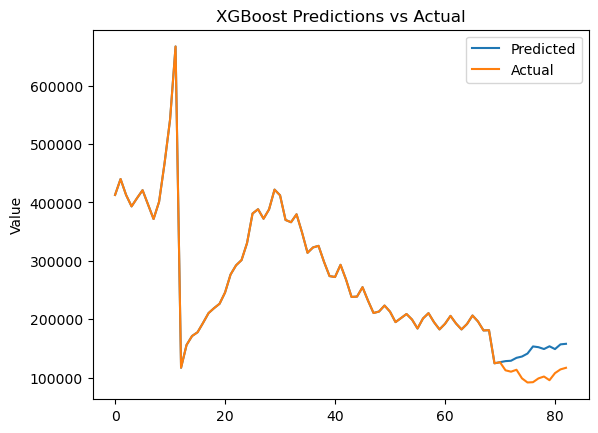

In [40]:
plt.plot(predictions, label='Predicted')
plt.plot(df_test['us bankruptcy'].values, label='Actual')
plt.ylabel('Value')
plt.title('XGBoost Predictions vs Actual')
plt.legend()
plt.show()